# Датасет: SSN и границы солнечных циклов

To forecast parameters of solar cycle 26, *monthly mean total sunspot number* data is used (source: [WDC-SILSO](https://www.sidc.be/SILSO/datafiles), Royal Observatory of Belgium, Brussels).

Data description:
> Monthly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each calendar month. Monthly means are available only since 1749 because the original observations compiled by Rudolph Wolf were too sparse before that year. A value of -1 indicates missing value. Data before SC 1 (until 1755-02) was dismissed from the dataset.

Error values:
> The monthly standard deviation of individual data is derived from the daily values by:
σ(m)=sqrt(SUM(N(d)*σ(d)^2)/SUM(N(d)))
where σ(d) is the standard deviation for a single day and N(d) is the number of observations for that day.
The standard error on the monthly mean values can be computed by:
σ/sqrt(N)
where σ is the listed standard deviation and N the total number of observations in the month.

CSV file contents:
> * Column 1-2: Gregorian calendar date
* Column 3: Date in fraction of year.
* Column 4: Monthly mean total sunspot number.
* Column 5: Monthly mean standard deviation of the input sunspot numbers.

      year  month  yearfrac    ssn  sigma
0     1755      2  1755.123   18.7   -1.0
1     1755      3  1755.204   11.3   -1.0
2     1755      4  1755.288   10.8   -1.0
3     1755      5  1755.371    0.0   -1.0
4     1755      6  1755.455    0.0   -1.0
...    ...    ...       ...    ...    ...
3219  2023      5  2023.371  137.4   19.6
3220  2023      6  2023.453  160.5   20.0
3221  2023      7  2023.538  159.1   17.3
3222  2023      8  2023.623  114.8   15.4
3223  2023      9  2023.705  133.6   17.6

[3224 rows x 5 columns]

n y_min m_min y_max m_max ssn_max
1 1755 02 1761 06 144 

2 1766 06 1769 09 193 

3 1775 06 1778 05 264 

4 1784 09 1788 02 235 

5 1798 04 1805 02 82 

6 1810 07 1816 05 81 

7 1823 05 1829 11 119 

8 1833 11 1837 03 245 

9 1843 07 1848 02 220 

10 1855 12 1860 02 186 

11 1867 03 1870 08 234 

12 1878 12 1883 12 124 

13 1890 03 1894 01 147 

14 1902 01 1906 02 107 

15 1913 07 1917 08 176 

16 1923 08 1928 04 130 

17 1933 09 1937 04 199 

18 1944 02 1947 05 219

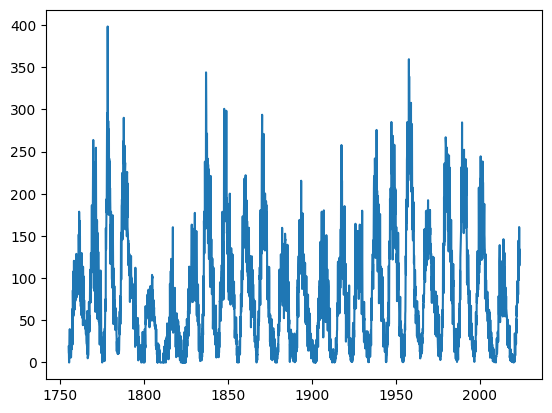

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import sklearn
import scipy
from sympy import fwht, ifwht
from sympy.combinatorics import GrayCode
from scipy import stats

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/input.csv", sep=';', header = 0)
print(data)
plt.plot(data['yearfrac'],data['ssn'])

f = open('/content/drive/MyDrive/Colab Notebooks/timeframe-wiki.txt')
s = f.read().splitlines()
f.close()
s = list(map(lambda x:x.split(), s))
print('\nn y_min m_min y_max m_max ssn_max')
for i in s:
    for j in i:
        print(j, sep='\t', end=' ')
    print('\n')

# Предварительная обработка данных: деление временного ряда на циклы

Выделяем начало / конец каждого цикла. Используем данные [NGDC NOAA](https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-indices/sunspot-numbers/cycle-data/table_cycle-dates_maximum-minimum.txt) или [Википедии](https://en.wikipedia.org/wiki/List_of_solar_cycles) о датах максимума и минимума. Находим индексы строк, соответствующих минимумам солнечной активности (=началам солнечных циклов), в файле наблюдений ***input.csv*** и связываем их с номерами циклов по информации Википедии в файле ***timeframe-wiki.txt***:

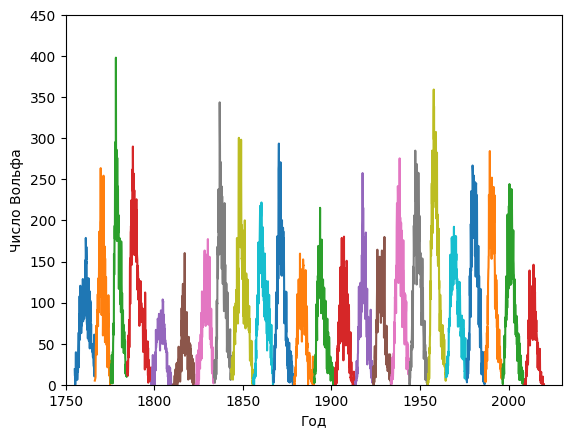

In [2]:
sc_minima_indices = []
for i in range(len(s)):
  sc_minima_indices.append(i+1)
  sc_minima_indices.append(data[(data['year'] == int(s[i][1])) & (data['month'] == int(s[i][2]))].index[0])

list2 = [] #разделить номер цикла и точку начала цикла в файле наблюдений
list2.append(sc_minima_indices[::2])
list2.append(sc_minima_indices[1::2])

cycles_data = dict() #создать словарь из датафреймов каждого цикла
cycles_binwidth = list() #используем этот список для int метода в следующем блоке
cycles_width = list()
cycles_length = list()
for i in range(24):
  cycles_data['num_%s' % (i+1)] = data[(list2[1][i]):(list2[1][i+1])]
  cycles_binwidth.append(int(cycles_data['num_%s' % (i+1)].shape[0] / 16))
  cycles_width.append(cycles_data['num_%s' % (i+1)].shape[0] / 16)
  cycles_length.append(cycles_data['num_%s' % (i+1)].shape[0])

for i in range(24):
  plt.plot(cycles_data['num_%s' % (i+1)]['yearfrac'], cycles_data['num_%s' % (i+1)]['ssn'])
plt.xlim(1750, 2030), plt.xlabel('Год')
plt.ylim(0, 450), plt.ylabel('Число Вольфа')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/cycles.png')

# *Деление циклов на фазы: метод обрезания хвоста*

Нужно перейти к фазам цикла, чтобы посмотреть, как первая фаза меняется с каждым из 24 циклов, как - вторая и т.д., всего получив 16 рядов значений: число пятен в фазе i, зависящее от номера цикла. Важно помнить о способе целочисленного деления циклов на 16 бинов. Ниже реализован метод "обрезания хвоста": округляем по int() результат деления длины цикла на 16, считываем только 16 первых результатов, "лишние" дни остаются в хвосте. Можно посмотреть, насколько обрезанные данные не соответствуют исходным:

In [3]:
name_ssn = "phase_ssn_"
name_sigma = "phase_sigma_"
ssn_matrix_old = list()
sigma_matrix_old = list()
#выделить 16 фаз каждого из циклов без обработки "лишних дней", методом int() - округления снизу
for k in range(16):
  exec(name_ssn + "%s = list()" % (k+1))
  exec(name_sigma + "%s = list()" % (k+1))
  for i in range(24):
    temp_ssn = list()
    temp_sigma = list()
    for j in range(cycles_binwidth[i]):
      temp_ssn.append(cycles_data['num_%s' % (i+1)]['ssn'].values[j+k*cycles_binwidth[i]])
      temp_sigma.append(cycles_data['num_%s' % (i+1)]['sigma'].values[j+k*cycles_binwidth[i]])
    exec(name_ssn + "%s.append(round(np.mean(temp_ssn), 2))" % (k+1))
    exec(name_sigma + "%s.append(round(np.mean(temp_sigma), 2))" % (k+1))
  exec("ssn_matrix_old.append(" + name_ssn + "%s)" % (k+1))
  exec("sigma_matrix_old.append(" + name_sigma + "%s)" % (k+1))

for j in range(16): #матрица: в строке слева направо - ссн циклов от 1го до 24го
  for i in range(24): #в столбцах сверху вниз - ссн по фазам от 1й до 16й
    print(ssn_matrix_old[j][i], end='\t') #3 строка, 2 столбец: 3я фаза 2го цикла
  print('\n')

11.26	7.03	12.53	22.52	5.62	0.0	0.11	12.63	18.54	5.98	12.28	4.8	12.75	5.3	3.24	10.43	5.81	9.74	5.29	18.85	20.27	13.86	12.87	2.5	

20.27	50.65	22.37	70.14	12.09	3.14	17.84	29.0	26.26	13.35	39.95	25.01	36.09	20.89	12.63	31.06	15.47	29.29	21.86	24.41	21.29	42.23	37.52	13.75	

18.65	65.98	34.78	169.52	13.83	6.96	12.63	59.37	63.16	49.66	87.51	59.76	86.78	47.45	39.03	34.04	29.96	64.47	74.33	62.06	45.94	66.86	88.4	25.29	

50.9	94.35	93.42	223.94	37.2	12.5	30.74	149.73	90.31	83.0	121.94	84.0	122.26	67.97	92.23	84.46	78.74	105.83	163.61	116.35	109.86	154.61	125.32	54.2	

80.84	122.23	182.33	224.44	59.61	26.04	32.77	189.71	108.09	144.1	209.31	95.74	129.24	86.14	93.11	114.04	110.94	176.01	240.1	136.94	157.6	202.27	158.93	98.6	

75.46	134.6	267.18	195.04	77.29	23.58	60.73	262.11	182.98	185.99	220.92	102.55	148.43	109.42	88.31	111.4	178.97	212.73	258.7	149.65	194.69	216.87	168.92	90.89	

90.89	219.0	261.92	179.34	66.41	53.56	83.27	212.74	201.89	179.23	192.88	96.39	135.76	97.69	158.33	119.8	196.09	1

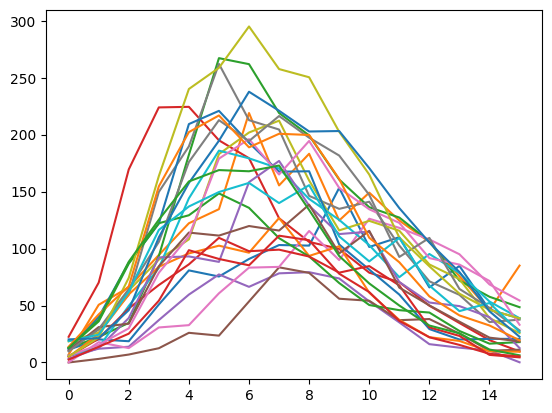

In [4]:
plt.plot(ssn_matrix_old) #24 цикла усреднили по 16 значений и наложили друг на друга
plt.show()

# Деление циклов на фазы: метод взвешивания

Для честного разбиения данных важно, чтобы обрезания хвоста не происходило. Поэтому SSN в месяцы, расположенные на границе между фазами, будет суммироваться с другими SSN месяцев фазы, но с поправочным коэффициентом - весом от 0 до 1. Сумма взвешенных значений будет делиться не на число месяцев, данные об SSN которых использовались, а на среднюю ширину фазы - нецелое число.

Сначала создаем список, который хранит вес всех месяцев внутри каждого солнечного цикла.

In [5]:
weights = [] #список весов для всех месяцев всех циклов
phase_numbers = [] #список номеров фаз для всех месяцев всех циклов
for i in range(24):
    temp = [] #список весов для каждого месяца в отдельно взятом цикле
    phnum = [] #список номеров фаз для каждого месяца в отдельно взятом цикле
    for m in range(cycles_length[i]):
      temp.append(0) #чтобы потом присваивать значения по индексам, заполняем список весов нулями
      phnum.append(0)
    #1 фаза цикла
    temp[:cycles_binwidth[i]] = [1]*cycles_binwidth[i]
    phnum[:cycles_binwidth[i]] = [1]*cycles_binwidth[i]
    temp[cycles_binwidth[i]] = cycles_width[i] - cycles_binwidth[i]
    phnum[cycles_binwidth[i]] = 1.5
    lst = temp[cycles_binwidth[i]] #запоминаем вес последнего месяца фазы
    #2-15 фазы цикла
    for q in range(14):
      nxt = 1 - lst #вычисляем, какой будет вес у этого же месяца в следующей фазе
      nmnth = int(cycles_width[i]-nxt) #вычисляем, сколько в фазе уложится месяцев с весом 1
      for p in range(nmnth):
        temp[temp.index(0)] = 1
        phnum[phnum.index(0)] = q+2
      temp[temp.index(0)] = cycles_width[i]-nxt-nmnth
      phnum[phnum.index(0)] = q+2.5
      lst = cycles_width[i]-nxt-nmnth
    #16 фаза цикла
    while (temp.index(0) < cycles_length[i]-1):
      temp[temp.index(0)] = 1
    while (phnum.index(0) < cycles_length[i]-1):
      phnum[phnum.index(0)] = 16
    temp[-1] = 1
    phnum[-1] = 16
    #собираем циклы воедино
    weights.append(temp)
    phase_numbers.append(phnum)
#weights[2][3] - вес 4 месяца для 3 солнечного цикла, phase_numbers[2][3] - номер фазы для того же месяца

Теперь, наконец, усредняем значения SSN по фазам со взвешиванием значений. Можно увидеть, как выглядит разбиение относительно предыдущего и относительно оригинальной картины цикла.

In [6]:
name_ssn = "phase_ssn_"
name_sigma = "phase_sigma_"
ssn_matrix = list()
sigma_matrix = list()

for k in range(16):
  exec(name_ssn + "%s = list()" % (k+1))
  exec(name_sigma + "%s = list()" % (k+1))
  for i in range(24):
    wd = cycles_width[i]
    ssn_wsum, sigma_wsum = 0, 0
    for j in range(cycles_length[i]): #для всех месяцев в i-м цикле взвешиваем ssn и sigma, суммируем
      if (abs(phase_numbers[i][j]-1 - k) <= 0.5): #если этот месяц внутри фазы или на её границе
        ssn_wsum += cycles_data['num_%s' % (i+1)]['ssn'].values[j]*weights[i][j]
        sigma_wsum += cycles_data['num_%s' % (i+1)]['sigma'].values[j]*weights[i][j]
      else: #если этот месяц относится к другой фазе
        ssn_wsum += 0
        sigma_wsum += 0
    exec(name_ssn + "%s.append(round(ssn_wsum/wd, 2))" % (k+1))
    exec(name_sigma + "%s.append(round(sigma_wsum/wd, 2))" % (k+1))
  exec("ssn_matrix.append(" + name_ssn + "%s)" % (k+1))
  exec("sigma_matrix.append(" + name_sigma + "%s)" % (k+1))

for j in range(16): #матрица: в строке слева направо - ссн циклов от 1го до 24го
  for i in range(24): #в столбцах сверху вниз - ссн по фазам от 1й до 16й
    print(ssn_matrix[j][i], end='\t') #например 3 строка, 2 столбец: 3я фаза 2го цикла
  print('\n')

12.92	9.81	12.62	23.22	5.56	0.0	3.88	12.64	19.08	6.25	12.81	5.48	13.06	5.83	3.33	9.88	7.16	10.89	6.19	19.14	21.32	15.75	13.21	2.42	

19.99	54.76	24.01	69.69	11.92	4.98	15.54	27.5	25.69	14.09	45.43	25.88	48.0	22.43	14.46	34.83	17.32	34.4	28.59	26.27	27.11	42.01	37.16	13.96	

22.24	78.18	53.03	165.01	15.17	6.18	19.68	66.66	66.14	57.9	97.88	64.28	97.43	49.07	45.86	38.17	43.55	62.46	107.94	66.13	63.35	84.34	91.19	26.12	

69.38	112.32	148.78	230.49	38.99	16.79	30.44	196.58	97.6	90.23	136.49	88.26	130.11	76.34	93.46	106.88	99.64	139.56	209.61	126.96	133.4	165.95	146.18	74.35	

77.65	133.68	244.39	229.19	65.12	26.51	51.7	196.28	104.39	163.14	233.91	109.88	144.38	94.16	94.76	92.45	121.73	182.21	243.84	133.04	182.89	221.92	164.06	101.94	

90.2	197.67	294.33	210.64	82.94	29.09	72.68	270.67	208.91	169.89	186.52	84.41	140.34	94.04	112.94	138.49	178.28	215.36	284.69	160.21	232.0	185.48	170.91	92.81	

97.84	204.38	227.35	160.66	63.29	67.78	80.42	235.4	213.68	190.67	174.82	104.76	103.73	100.49	181.46

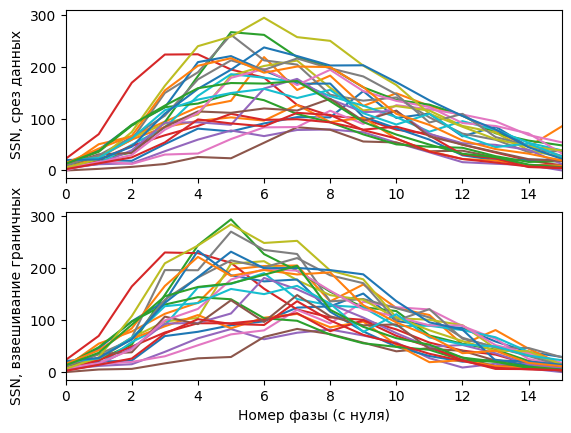

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ssn_matrix_old), ax2.plot(ssn_matrix)
ax1.set_xlim(0,15), ax2.set_xlim(0,15)
ax2.set_xlabel('Номер фазы (c нуля)')
ax1.set_ylabel('SSN, срез данных')
ax2.set_ylabel('SSN, взвешивание граничных')
plt.show()

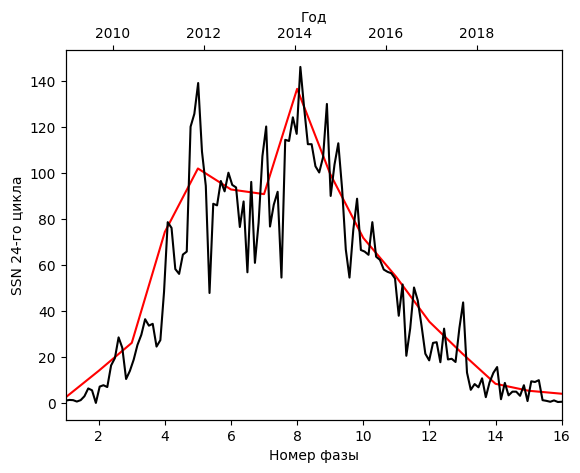

In [8]:
ssn_transposed = np.transpose(ssn_matrix) #24 строки у траспонированного, 16 столбцов
sigma_transposed = np.transpose(sigma_matrix)
n=24
#n = int(input("Введите номер цикла, для которого проверяется качество усреднения по фазам: "))
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(range(1,17), ssn_transposed[n-1], color='red')
ax2.plot(cycles_data['num_%s' % n]['yearfrac'], cycles_data['num_%s' % n]['ssn'], color='black')
ax1.set_xlim(1,16)
ax2.set_xlim(cycles_data['num_%s' % n]['yearfrac'].values[0],cycles_data['num_%s' % n]['yearfrac'].values[-1])
ax1.set_xlabel('Номер фазы'), ax2.set_xlabel('Год')
ax1.set_ylabel('SSN %s-го цикла' % n)
plt.show()

# *Декомпозиция: FWHT и код Грея*

Если число фаз в цикле представимо в виде 2n, становится возможным разложение временного ряда в обобщенный ряд Фурье с базисными функциями Уолша. Номер функции (или строки в матрице) по Уолшу можно получить из номера функции по Адамару в 4 этапа:
*   Сначала номер строки записывается в двоичной системе счисления,
*   потом биты в записи переставляются в обратном порядке.
*   Затем применяется код Грея – двоичный код, в котором две соседние кодовые комбинации различаются только в одном двоичном разряде.
*   Полученная запись переводится из двоичной системы в десятичную.

Так получается базисная матрица Уолша.

[Walsh transform documentation](https://www.geeksforgeeks.org/python-fast-walsh-hadamard-transform/), [Gray code documentation](https://docs.sympy.org/latest/modules/combinatorics/graycode.html)

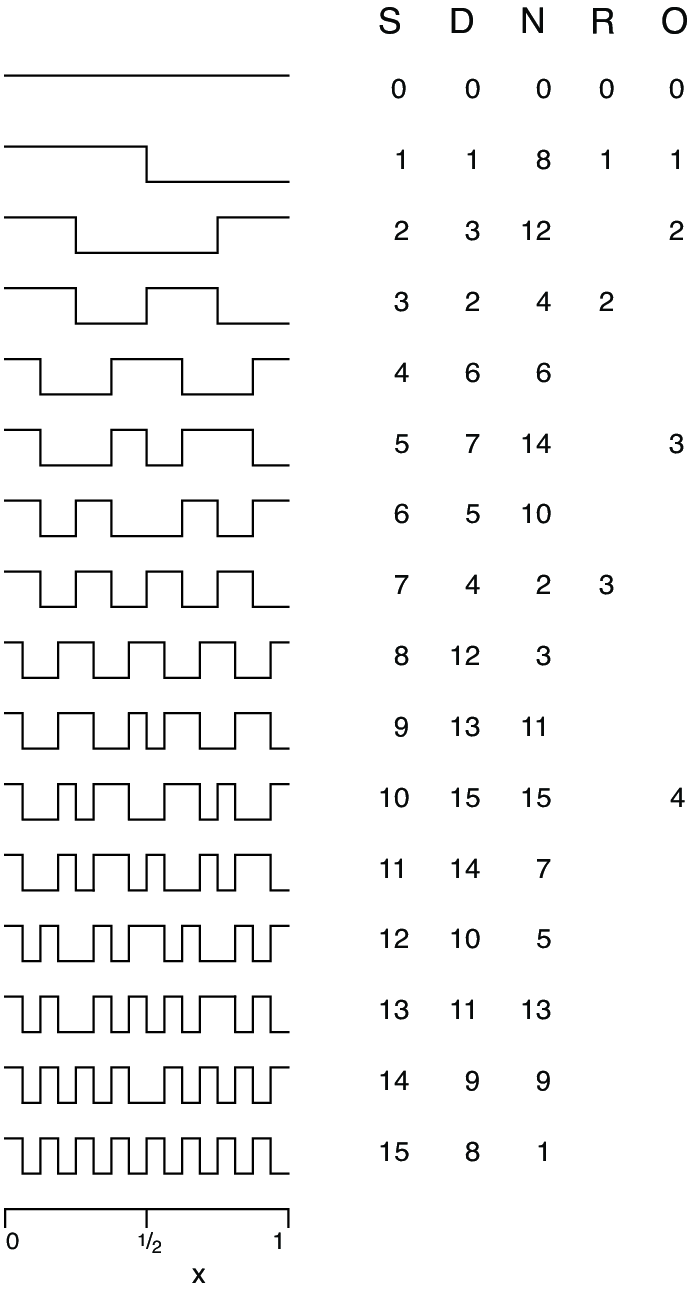

In [9]:
ssn_tmp = []
for i in range(24):
  #применяем преобразование Уолша к матрице 24*16 построчно, преобразованная расположена по Адамару
  ssn_tmp.append(fwht(ssn_transposed[i]))

#по этому порядку расположить значения внутри tmp: это базисные функции Уолша, расположенные по коду Грея
numer = [0,8,12,4,6,14,10,2,3,11,15,7,5,13,9,1]
ssn_walsh = []
tmpp = []
for i in range(24):
  tmpp = ssn_tmp[i]
  ssn_walshh = []
  for j in numer:
    ssn_walshh.append(tmpp[j])
  ssn_walsh.append(ssn_walshh)

for i in range(16): #итоговая матрица преобразованных значений, расположенная по Грею: 1 столбец - это первый коэффициент для 24 циклов, и т.д., всего 16 коэффициентов согл. фазам
  for j in range(24):
    print(format(np.transpose(ssn_walsh)[i][j], '.5g'), end='\t')
  print('\n')
#plt.plot(ssn_walsh) #визуализируем изменение преобразованных значений с фазой

1192.8	1729.4	1799.6	1656.2	626.81	503.41	1060.0	1927.0	1587.8	1465.7	1402.5	904.32	1050.7	891.29	1177.2	1094.8	1532.7	1801.0	2098.8	1392.8	1817.1	1693.2	1404.2	839.37	

-163.91	263.05	600.07	762.54	90.870	-34.370	-271.30	539.59	237.32	200.23	730.04	285.78	501.14	220.57	234.23	236.86	190.61	331.84	666.39	303.62	304.75	507.32	625.97	238.55	

-519.89	-830.39	-1059.4	-476.36	-419.91	-341.87	-539.80	-943.87	-804.90	-725.53	-694.14	-428.80	-362.60	-507.37	-639.43	-525.88	-804.71	-994.22	-1082.5	-601.40	-1049.2	-863.76	-701.55	-527.63	

-10.930	-141.77	-386.51	11.240	-11.210	-15.370	29.280	-309.19	-186.20	-266.49	-267.96	-25.700	-34.880	10.190	-143.61	-46.780	-247.93	-149.38	-273.37	-141.02	-91.930	-104.52	-177.63	-82.890	

8.8900	-50.270	-253.21	-443.08	5.3700	96.010	-85.600	-216.91	-47.280	-148.57	-154.68	-1.5200	-242.42	-30.590	59.110	-56.840	-30.850	-64.420	-167.17	-141.46	-79.850	-107.64	-73.430	9.3700	

-17.830	-44.690	-309.27	-479.48	-96.570	58.750	176.28	-237.27	-35.740	-110.17	-331.

Этого можно было достичь прямым расписыванием функций Уолша:

```
a = np.transpose(ssn_matrix)
q = []
for i in range(24): #матрица: в столбцах сверху вниз - ссн циклов от 1го до 24го
  q1 = +np.sum(a[i])
  q2 = +np.sum(a[i][0:8])-np.sum(a[i][8:16])
  q3 = +np.sum(a[i][0:4])-np.sum(a[i][4:8])-np.sum(a[i][8:12])+np.sum(a[i][12:16])
  q4 = +np.sum(a[i][0:4])-np.sum(a[i][4:8])+np.sum(a[i][8:12])-np.sum(a[i][12:16])
  q5 = +np.sum(a[i][0:2])-np.sum(a[i][2:6])+np.sum(a[i][6:10])-np.sum(a[i][10:14])+np.sum(a[i][14:16])
  q6 = +np.sum(a[i][0:2])-np.sum(a[i][2:6])+np.sum(a[i][6:8])-np.sum(a[i][8:10])+np.sum(a[i][10:14])-np.sum(a[i][14:16])
  q7 = +np.sum(a[i][0:2])-np.sum(a[i][2:4])+np.sum(a[i][4:6])-np.sum(a[i][6:10])+np.sum(a[i][10:12])-np.sum(a[i][12:14])+np.sum(a[i][14:16])
  q8 = +np.sum(a[i][0:2])-np.sum(a[i][2:4])+np.sum(a[i][4:6])-np.sum(a[i][6:8])+np.sum(a[i][8:10])-np.sum(a[i][10:12])+np.sum(a[i][12:14])-np.sum(a[i][14:16])
  q9 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:5])-np.sum(a[i][5:7])+np.sum(a[i][7:9])-np.sum(a[i][9:11])+np.sum(a[i][11:13])-np.sum(a[i][13:15])+np.sum(a[i][15:16])
  q10 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:5])-np.sum(a[i][5:7])+np.sum(a[i][7:8])-np.sum(a[i][8:9])+np.sum(a[i][9:11])-np.sum(a[i][11:13])+np.sum(a[i][13:15])-np.sum(a[i][15:16])
  q11 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:4])-np.sum(a[i][4:5])+np.sum(a[i][5:7])-np.sum(a[i][7:9])+np.sum(a[i][9:11])-np.sum(a[i][11:12])+np.sum(a[i][12:13])-np.sum(a[i][13:15])+np.sum(a[i][15:16])
  q12 = +np.sum(a[i][0:1])-np.sum(a[i][1:3])+np.sum(a[i][3:4])-np.sum(a[i][4:5])+np.sum(a[i][5:7])-np.sum(a[i][7:8])+np.sum(a[i][8:9])-np.sum(a[i][9:11])+np.sum(a[i][11:12])-np.sum(a[i][12:13])+np.sum(a[i][13:15])-np.sum(a[i][15:16])
  q13 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:5])+np.sum(a[i][5:6])-np.sum(a[i][6:7])+np.sum(a[i][7:9])-np.sum(a[i][9:10])+np.sum(a[i][10:11])-np.sum(a[i][11:13])+np.sum(a[i][13:14])-np.sum(a[i][14:15])+np.sum(a[i][15:16])
  q14 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:5])+np.sum(a[i][5:6])-np.sum(a[i][6:7])+np.sum(a[i][7:8])-np.sum(a[i][8:9])+np.sum(a[i][9:10])-np.sum(a[i][10:11])+np.sum(a[i][11:13])-np.sum(a[i][13:14])+np.sum(a[i][14:15])-np.sum(a[i][15:16])
  q15 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:4])+np.sum(a[i][4:5])-np.sum(a[i][5:6])+np.sum(a[i][6:7])-np.sum(a[i][7:9])+np.sum(a[i][9:10])-np.sum(a[i][10:11])+np.sum(a[i][11:12])-np.sum(a[i][12:13])+np.sum(a[i][13:14])-np.sum(a[i][14:15])+np.sum(a[i][15:16])
  q16 = +np.sum(a[i][0:1])-np.sum(a[i][1:2])+np.sum(a[i][2:3])-np.sum(a[i][3:4])+np.sum(a[i][4:5])-np.sum(a[i][5:6])+np.sum(a[i][6:7])-np.sum(a[i][7:8])+np.sum(a[i][8:9])-np.sum(a[i][9:10])+np.sum(a[i][10:11])-np.sum(a[i][11:12])+np.sum(a[i][12:13])-np.sum(a[i][13:14])+np.sum(a[i][14:15])-np.sum(a[i][15:16])
  q.append([q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15, q16])

for i in range(24):
  for j in range(16):
    print(format(q[i][j], '.5g'), end='\t')
  print('\n')
```

# Аппроксимация: выделение тренда

По методу главных компонентов (англ. principal component analysis, PCA) происходит последовательно выделение:
*   Level: The average value in the series.
*   Trend: The increasing or decreasing value in the series.
*   Seasonality: The repeating short-term cycle in the series.
*   Noise: The random variation in the series.

На каждом этапе используем [normal probability test](https://en.wikipedia.org/wiki/Normal_probability_plot) для проверки случайности остатков ([документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)).




```
#коэффициенты разложения для нечетных циклов после выделения тренда с помощью tablecurve. для четных: в 3 строчке будет range(1,25,2)
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
ssn_waltp = np.transpose(ssn_walsh)
for i in range(0, 24, 2):
  qoddt1.append(np.array(ssn_walsh[i][0]-1111.234-23.7181*(i+1)))
  qoddt2.append(np.array(ssn_walsh[i][1]+60.7837-169.0191*np.log(i+1)))
  qoddt3.append(np.array(ssn_walsh[i][2]-575.45+12.31*(i+1)))
  qoddt4.append(np.array(ssn_walsh[i][3]+84.41+29.83*np.log(i+1)))
  qoddt5.append(np.array(ssn_walsh[i][4]))
  qoddt6.append(np.array(ssn_walsh[i][5]+52.96+8.13*(i+1)))
  qoddt7.append(np.array(ssn_walsh[i][6]+175.33+10.38*(i+1)))
  qoddt8.append(np.array(ssn_walsh[i][7]-65.65+5.32*(i+1)))
  qoddt9.append(np.array(ssn_walsh[i][8]+20.03-2.59*(i+1)))
  qoddt10.append(np.array(ssn_walsh[i][9]-51.25+20.25*np.log(i+1)))
  qoddt11.append(np.array(ssn_walsh[i][10]))
  qoddt12.append(np.array(ssn_walsh[i][11]))
  qoddt13.append(np.array(ssn_walsh[i][12]))
  qoddt14.append(np.array(ssn_walsh[i][13]-3.16+19.84*np.log(i+1)))
  qoddt15.append(np.array(ssn_walsh[i][14]+108.56+4.10*(i+1)))
  qoddt16.append(np.array(ssn_walsh[i][15]+56.91-12.22*np.log(i+1)))
qoddt = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])
plt.plot(range(12), qoddt[3]) #ряд с сезонностью и остатками
```





```
qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(0, 24, 2):
  qoddt1.append(ssn_walsh[i][0])
  qoddt2.append(ssn_walsh[i][1])
  qoddt3.append(ssn_walsh[i][2])
  qoddt4.append(ssn_walsh[i][3])
  qoddt5.append(ssn_walsh[i][4])
  qoddt6.append(ssn_walsh[i][5])
  qoddt7.append(ssn_walsh[i][6])
  qoddt8.append(ssn_walsh[i][7])
  qoddt9.append(ssn_walsh[i][8])
  qoddt10.append(ssn_walsh[i][9])
  qoddt11.append(ssn_walsh[i][10])
  qoddt12.append(ssn_walsh[i][11])
  qoddt13.append(ssn_walsh[i][12])
  qoddt14.append(ssn_walsh[i][13])
  qoddt15.append(ssn_walsh[i][14])
  qoddt16.append(ssn_walsh[i][15])
ssn_waltp = np.array([qoddt1, qoddt2, qoddt3, qoddt4, qoddt5, qoddt6, qoddt7, qoddt8, qoddt9, qoddt10, qoddt11, qoddt12, qoddt13, qoddt14, qoddt15, qoddt16])
ssn_waltp
```



Q1 before trend subtraction (best result): r^2 = 0.9772
Q2 R^2 improvement after trend subtraction: +0.00417 resulting in r^2 = 0.954
Q3 R^2 improvement after trend subtraction: +0.0173 resulting in r^2 = 0.9707
Q4 before trend subtraction (best result): r^2 = 0.9633
Q5 before trend subtraction (best result): r^2 = 0.9611
Q6 R^2 improvement after trend subtraction: +0.0135 resulting in r^2 = 0.9741
Q7 before trend subtraction (best result): r^2 = 0.971
Q8 before trend subtraction (best result): r^2 = 0.9767
Q9 before trend subtraction (best result): r^2 = 0.9147
Q10 before trend subtraction (best result): r^2 = 0.8441
Q11 before trend subtraction (best result): r^2 = 0.9727
Q12 before trend subtraction (best result): r^2 = 0.9707
Q13 before trend subtraction (best result): r^2 = 0.8814
Q14 before trend subtraction (best result): r^2 = 0.964
Q15 R^2 improvement after trend subtraction: +0.0292 resulting in r^2 = 0.9419
Q16 R^2 improvement after trend subtraction: +0.0211 resulting in r^

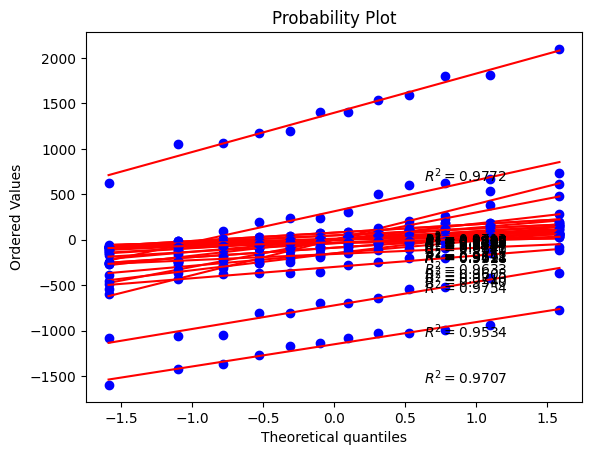

In [10]:
qoddt= np.array([[57.8979000000002, 617.181700000000, -603.014500000000,
        -217.280700000000, 263.123100000000, 30.3669000000001,
        -368.829300000000, -289.755500000000, 18.2683000000001,
        536.952100000000, 207.795900000000, -252.580300000000],
       [-103.126300000000, 475.167239720376, -120.372047465490,
        -539.412282074195, -73.2692205592483, 385.533599097365,
        128.398268056273, -162.698507745115, -227.473469520372,
        229.507273736370, -149.048742353819, 156.795289568449],
       [-1083.03000000000, -1597.89000000000, -933.810000000000,
        -1029.08000000000, -1269.56000000000, -1134.18000000000,
        -778.020000000000, -1030.23000000000, -1170.89000000000,
        -1424.09000000000, -1366.15000000000, -993.870000000000],
       [73.4800000000000, -269.328395429030, 121.209532927909,
        171.736499746320, -36.2467908580606, -112.020784012425,
        126.042439333078, 21.5811374988789, -79.0052459468031,
        -101.127385251465, 83.2981043172898, 0.311792461166476],
       [8.89000000000003, -253.210000000000, 5.36999999999996,
        -85.6000000000000, -47.2800000000000, -154.680000000000,
        -242.420000000000, 59.1100000000000, -30.8500000000000,
        -167.170000000000, -79.8500000000000, -73.4300000000000],
       [43.2599999999999, -231.920000000000, -2.96000000000000,
        286.150000000000, 90.3900000000000, -189.590000000000,
        -96.0900000000000, 139.200000000000, 172.540000000000,
        -244.500000000000, -21.1599999999999, 54.1600000000000],
       [-92.8600000000000, 2.00000000000007, 112.680000000000,
        42.6100000000000, -99.4100000000000, 39.4700000000000,
        159.750000000000, -101.460000000000, -29.4800000000000,
        -118.140000000000, 36.7800000000000, 47.8800000000001],
       [-7.65999999999995, 56.5400000000000, 19.9800000000000,
        -36.5100000000000, -42.4700000000000, 25.0500000000000,
        -14.7300000000000, -62.8800000000000, -19.3000000000000,
        14.1400000000000, 134.020000000000, -65.8800000000000],
       [55.3300000000000, 0.150000000000029, -13.2500000000000,
        -14.2000000000000, -90.8000000000000, 56.5000000000000,
        -5.64000000000000, -13.0300000000000, 0.950000000000024,
        -1.40999999999998, 2.06999999999999, 24.0100000000000],
       [18.7200000000000, -12.1331011544708, 26.0711177267905,
        39.6546805183701, -151.776202308942, 46.2873792741670,
        -13.4297755114039, -9.60198342768027, -46.0674297828616,
        65.5848893281204, 5.23157936389932, 31.4737578725653],
       [75.9500000000000, 186.070000000000, 27.0300000000000,
        38.3600000000000, 182.760000000000, -77.0800000000000,
        -12.5000000000000, 86.8700000000000, 105.970000000000,
        116.770000000000, 199.110000000000, 2.19000000000002],
       [-23.5300000000000, 146.610000000000, 18.4100000000000,
        -77.3600000000000, 149.180000000000, -12.9000000000000,
        9.58000000000002, 66.4100000000000, 104.990000000000,
        115.330000000000, 26.6700000000000, 39.1900000000000],
       [-67.3100000000000, -32.4500000000000, 42.0300000000000,
        -36.1200000000000, -25.3000000000000, -63.9000000000000,
        -60.1600000000000, -32.2700000000000, -16.6100000000000,
        -81.1900000000000, -42.9300000000000, -22.9300000000000],
       [33.6500000000000, -127.393532192825, -12.8587518173075,
        147.846857357257, 125.432935614351, -121.745757787680,
        -45.1114047479631, -42.2422840101322, 44.2609527460753,
        -21.8523306533379, 47.6733251644327, -27.8017947559657],
       [0.530000000000035, -101.250000000000, 27.5700000000000,
        54.8800000000000, -39.4000000000000, 65.7200000000000,
        74.7600000000000, 40.5100000000000, -50.4100000000000,
        -68.2900000000000, -45.5500000000000, 41.3700000000000],
       [-17.3000000000000, 15.5149578324757, 17.6126687100553,
        -50.4490220214559, 2.93991566495139, 60.6877197664039,
        -4.81368114818000, 43.5276265425310, 11.3581329356330,
        -62.3010443254139, 9.05593581101974, -25.8957393186542]])
ssn_waltpn = np.array([[1192.85000000000, 1799.57000000000, 626.810000000000,
        1059.98000000000, 1587.82000000000, 1402.50000000000,
        1050.74000000000, 1177.25000000000, 1532.71000000000,
        2098.83000000000, 1817.11000000000, 1404.17000000000],
       [-163.910000000000, 600.070000000000, 90.8700000000000,
        -271.300000000000, 237.320000000000, 730.040000000000,
        501.140000000000, 234.230000000000, 190.610000000000,
        666.390000000000, 304.750000000000, 625.970000000000],
       [-519.890000000000, -1059.37000000000, -419.910000000000,
        -539.800000000000, -804.900000000000, -694.140000000000,
        -362.600000000000, -639.430000000000, -804.710000000000,
        -1082.53000000000, -1049.21000000000, -701.550000000000],
       [-10.9300000000000, -386.510000000000, -11.2100000000000,
        29.2800000000000, -186.200000000000, -267.960000000000,
        -34.8800000000000, -143.610000000000, -247.930000000000,
        -273.370000000000, -91.9299999999999, -177.630000000000],
       [8.89000000000003, -253.210000000000, 5.36999999999996,
        -85.6000000000000, -47.2800000000000, -154.680000000000,
        -242.420000000000, 59.1100000000000, -30.8500000000000,
        -167.170000000000, -79.8500000000000, -73.4300000000000],
       [-17.8300000000001, -309.270000000000, -96.5700000000000,
        176.280000000000, -35.7400000000000, -331.980000000000,
        -254.740000000000, -35.7100000000000, -18.6300000000000,
        -451.930000000000, -244.850000000000, -185.790000000000],
       [-278.570000000000, -204.470000000000, -114.550000000000,
        -205.380000000000, -368.160000000000, -250.040000000000,
        -150.520000000000, -432.490000000000, -381.270000000000,
        -490.690000000000, -356.530000000000, -366.190000000000],
       [52.6700000000001, 106.230000000000, 59.0300000000000,
        -8.09999999999997, -24.7000000000000, 32.1800000000000,
        -18.2400000000000, -77.0300000000000, -44.0900000000000,
        -21.2900000000000, 87.9500000000000, -122.590000000000],
       [37.8900000000000, -12.1100000000000, -20.3300000000000,
        -16.1000000000000, -87.5200000000000, 64.9600000000000,
        8.00000000000000, 5.79000000000000, 24.9500000000000,
        27.7700000000000, 36.4300000000000, 63.5500000000000],
       [69.9700000000000, 16.8700000000000, 44.7300000000000,
        51.5000000000000, -145.020000000000, 48.9800000000000,
        -14.1200000000000, -13.1900000000000, -52.1900000000000,
        57.2100000000000, -5.16999999999999, 19.2300000000000],
       [75.9500000000000, 186.070000000000, 27.0300000000000,
        38.3600000000000, 182.760000000000, -77.0800000000000,
        -12.5000000000000, 86.8700000000000, 105.970000000000,
        116.770000000000, 199.110000000000, 2.19000000000002],
       [-23.5300000000000, 146.610000000000, 18.4100000000000,
        -77.3600000000000, 149.180000000000, -12.9000000000000,
        9.58000000000002, 66.4100000000000, 104.990000000000,
        115.330000000000, 26.6700000000000, 39.1900000000000],
       [-67.3100000000000, -32.4500000000000, 42.0300000000000,
        -36.1200000000000, -25.3000000000000, -63.9000000000000,
        -60.1600000000000, -32.2700000000000, -16.6100000000000,
        -81.1900000000000, -42.9300000000000, -22.9300000000000],
       [36.8100000000000, -146.030000000000, -41.6300000000000,
        112.400000000000, 85.0000000000000, -166.160000000000,
        -92.8400000000000, -92.8100000000000, -8.79000000000000,
        -77.1100000000001, -9.56999999999998, -86.8500000000000],
       [-112.130000000000, -222.110000000000, -101.490000000000,
        -82.3800000000000, -184.860000000000, -87.9400000000000,
        -87.1000000000000, -129.550000000000, -228.670000000000,
        -254.750000000000, -240.210000000000, -161.490000000000],
       [-74.2100000000000, -27.9700000000000, -19.6300000000000,
        -83.5800000000000, -27.1200000000000, 33.0800000000000,
        -30.3800000000000, 19.7100000000000, -10.9300000000000,
        -83.2300000000000, -10.6500000000000, -44.4900000000000]])

# посмотрим на смещение R^2 у рядов до и после выделения тренда
for j in range(16):
  fig1 = stats.probplot(qoddt[j], plot=plt, rvalue=True)
  fig2 = stats.probplot(ssn_waltpn[j], plot=plt, rvalue=True)
  if round(fig1[-1][-1]**2-fig2[-1][-1]**2, 3) <= 0:
      qoddt[j] = ssn_waltpn[j]
      print('Q' + str(j+1) + ' before trend subtraction (best result): r^2 = ' + format(fig2[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after trend subtraction: +' + format(fig1[-1][-1]**2-fig2[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig1[-1][-1]**2, '.4g'))

# Аппроксимация: выделение сезонности

Пользуюсь [калькулятором синусоиды](https://stats.blue/Stats_Suite/sinusoidal_regression_calculator.html) для выделения тренда.

In [11]:
for i in range(16):
  for j in range(12):
    print(format(qoddt[i][j], '.4g'), end = '\t')
  print('\n')

1193	1800	626.8	1060	1588	1402	1051	1177	1533	2099	1817	1404	

-103.1	475.2	-120.4	-539.4	-73.27	385.5	128.4	-162.7	-227.5	229.5	-149	156.8	

-1083	-1598	-933.8	-1029	-1270	-1134	-778	-1030	-1171	-1424	-1366	-993.9	

-10.93	-386.5	-11.21	29.28	-186.2	-268	-34.88	-143.6	-247.9	-273.4	-91.93	-177.6	

8.89	-253.2	5.37	-85.6	-47.28	-154.7	-242.4	59.11	-30.85	-167.2	-79.85	-73.43	

43.26	-231.9	-2.96	286.1	90.39	-189.6	-96.09	139.2	172.5	-244.5	-21.16	54.16	

-278.6	-204.5	-114.5	-205.4	-368.2	-250	-150.5	-432.5	-381.3	-490.7	-356.5	-366.2	

52.67	106.2	59.03	-8.1	-24.7	32.18	-18.24	-77.03	-44.09	-21.29	87.95	-122.6	

37.89	-12.11	-20.33	-16.1	-87.52	64.96	8	5.79	24.95	27.77	36.43	63.55	

69.97	16.87	44.73	51.5	-145	48.98	-14.12	-13.19	-52.19	57.21	-5.17	19.23	

75.95	186.1	27.03	38.36	182.8	-77.08	-12.5	86.87	106	116.8	199.1	2.19	

-23.53	146.6	18.41	-77.36	149.2	-12.9	9.58	66.41	105	115.3	26.67	39.19	

-67.31	-32.45	42.03	-36.12	-25.3	-63.9	-60.16	-32.27	-16.61	-81.19	-42.93	-22.93	

36.8

In [12]:
qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(12):
  qodds1.append(qoddt[0][i]-338.2801*math.sin(0.683*(2*i+1)+0.8495)-1380.2966)
  qodds2.append(qoddt[1][i]-302.3497*math.sin(0.714*(2*i+1)-0.4368)+27.965)
  qodds3.append(qoddt[2][i]-198.1385*math.sin(0.757*(2*i+1)+3.0164)+1147.2838)
  qodds4.append(qoddt[3][i]-149.9748*math.sin(0.8727*(2*i+1)+1.9902)+151.7084)
  qodds5.append(qoddt[4][i]-92.5597*math.sin(0.757*(2*i+1)+2.1645)+84.7953)
  qodds6.append(qoddt[5][i]-214.1079*math.sin(0.748*(2*i+1)+2.3752)-10.6195)
  qodds7.append(qoddt[6][i]-75.3903*math.sin(0.6614*(2*i+1)-1.0671)+305.5487)
  qodds8.append(qoddt[7][i]-64.8825*math.sin(0.748*(2*i+1)-0.7352)+1.3626)
  qodds9.append(qoddt[8][i]-25.5982*math.sin(0.5984*(2*i+1)+0.7234)-8.1498)
  qodds10.append(qoddt[9][i]-48.1767*math.sin(1.0134*(2*i+1)+1.6129)-8.3122)
  qodds11.append(qoddt[10][i]-89.1441*math.sin(1.0472*(2*i+1)-1.308)-77.635)
  qodds12.append(qoddt[11][i]-61.8904*math.sin(0.8727*(2*i+1)-0.973)-46.4486)
  qodds13.append(qoddt[12][i]-27.6512*math.sin(1.0649*(2*i+1)+3.0701)+36.5165)
  qodds14.append(qoddt[13][i]-81.5248*math.sin(0.6981*(2*i+1)+2.3238)+31.8725)
  qodds15.append(qoddt[14][i]-56.0413*math.sin(0.3927*(2*i+1)-2.7903)-11.4992)
  qodds16.append(qoddt[15][i]-23.9952*math.sin(0.4189*(2*i+1)+2.4171)-4.2817)
qodds = np.array([qodds1, qodds2, qodds3, qodds4, qodds5, qodds6, qodds7, qodds8, qodds9, qodds10, qodds11, qodds12, qodds13, qodds14, qodds15, qodds16])

Q1 before season subtraction (best result): r^2 = 0.9772
Q2 R^2 improvement after season subtraction: +0.00389 resulting in r^2 = 0.9579
Q3 before season subtraction (best result): r^2 = 0.9707
Q4 before season subtraction (best result): r^2 = 0.9633
Q5 R^2 improvement after season subtraction: +0.0039 resulting in r^2 = 0.965
Q6 R^2 improvement after season subtraction: +0.00428 resulting in r^2 = 0.9783
Q7 before season subtraction (best result): r^2 = 0.971
Q8 before season subtraction (best result): r^2 = 0.9767
Q9 before season subtraction (best result): r^2 = 0.9147
Q10 before season subtraction (best result): r^2 = 0.8441
Q11 before season subtraction (best result): r^2 = 0.9727
Q12 before season subtraction (best result): r^2 = 0.9707
Q13 R^2 improvement after season subtraction: +0.0128 resulting in r^2 = 0.8943
Q14 before season subtraction (best result): r^2 = 0.964
Q15 R^2 improvement after season subtraction: +0.000887 resulting in r^2 = 0.9428
Q16 before season subtractio

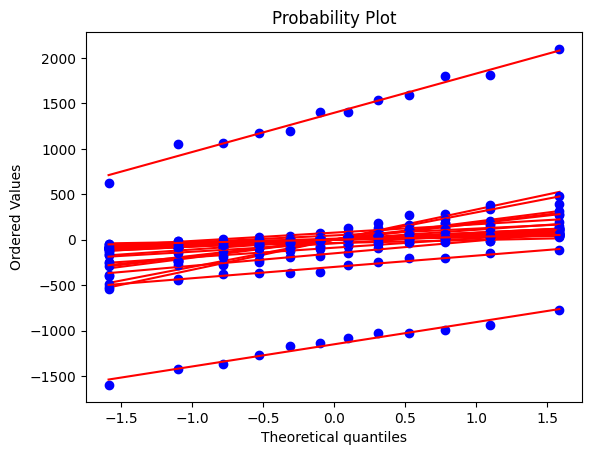

In [13]:
# посмотрим на смещение R^2 у рядов до и после выделения сезонности
for j in range(16):
  fig1 = stats.probplot(qoddt[j], plot=plt, rvalue=False)
  fig2 = stats.probplot(qodds[j], plot=plt, rvalue=False)
  if round(fig2[-1][-1]**2-fig1[-1][-1]**2, 3) <= 0:
      qodds[j] = qoddt[j]
      print('Q' + str(j+1) + ' before season subtraction (best result): r^2 = ' + format(fig1[-1][-1]**2, '.4g'))
  else:
      print('Q' + str(j+1) + ' R^2 improvement after season subtraction: +' + format(fig2[-1][-1]**2-fig1[-1][-1]**2, '.3g') + ' resulting in r^2 = ' + format(fig2[-1][-1]**2, '.4g'))

# Прогнозирование по фазам

Проводится прогноз экстраполяцией тренда T + сезонности S + дисперсии D для рядов Q1-Q16, отдельно для последовательностей четных и нечетных циклов. В работе составляется прогноз 25-го солнечного цикла, поэтому рассмотрена только экстраполяция последовательности нечетных циклов.

Есть много приколов  с учитыванием трендов и сезонности:

*   где-то аппроксимации не нужны вообще для наилучшей случайности;
*   где-то и тренд, и сезон улучшили случайность остаточного "шумового" ряда;
*   где-то тренд улучшил остаточный ряд, а сезон - нет, и наоборот.
Считая себя рациональными, сначала возьмем наилучшие совпавшие данные, все остальное заполним средними значениями фаз за все нечетные циклы.
В следующем шаге определим стандартные выборочные ошибки и те самые средние значения.

In [14]:
err = [np.std(qodds[i]) for i in range(16)]

means= []
mas = np.transpose(ssn_walsh)
for i in range(16):
  meanss = []
  for j in range(0, 24, 2):
      meanss.append(mas[i][j])
  means.append(np.mean(meanss))
  print(format(means[i], '.4g'), end='\n')

1396
312.2
-723.2
-150.2
-88.43
-150.6
-299.9
1.835
11.11
6.567
77.62
46.88
-36.60
-40.63
-157.7
-29.95


Теперь в ssn_extra загрузим средние + наилучшие значения экстраполяции, ssn_extra1 & ssn_extra2 - наилучшие + взвешенные по r^2 значения с учетом всех случаев.

In [16]:
#истинные + средние значения остальные
#ssn_extra = [1396, 155.6813, -723.2, -150.2, -88.43, -73.5463, -299.9, 1.835, 11.11, 6.567, 77.62, 46.88, -36.60, -40.63, -161.5289, -29.95]
#my way значения
#ssn_extra1 = [1295.349561, 155.6813, -869.7238574, -289.8425581, -12.19604234, -73.5463, -414.3491047, -57.90837766, 26.09183344, 39.41312584, 57.96008169, 100.2450119, -63.84666414, 24.63560442, -161.5289, -17.58230951]
#new way значения
ssn_extra = [1295.349561, 155.6813, -804.412, -289.8425581, -12.19604234, -73.5463, -414.3491047, -57.90837766, 26.09183344, 39.41312584, 57.96008169, 100.2450119, -63.84666414, 24.63560442, -161.5289, 3.248601]

#casenum = int(input())
#if casenum == 1:
#  ssn_walsh.append(ssn_extra)
#elif casenum == 2:
#  ssn_walsh.append(ssn_extra1)
#else:
#  ssn_walsh.append(ssn_extra2)
ssn_walsh.append(ssn_extra)

# Обратное преобразование к временному ряду

In [19]:
numer1 = [0, 15, 7, 8, 3, 12, 4, 11, 1, 14, 6, 9, 2, 13, 5, 10] #переходим от нумерации Грея к нумерации Адамара
ssn_forecasted = [] #финальная функция, которую будем прогонять через ifwht
tmppp = []
for i in range(25):
  tmppp = ssn_walsh[i]
  ssn_forecastedd = []
  for j in numer1:
    ssn_forecastedd.append(tmppp[j])
  ssn_forecasted.append(ssn_forecastedd)

ssn_res = []
for i in range(25):  #применяем обратное преобразование Уолша к матрице 25*16 построчно, преобразованная расположена по Адамару
  ssn_res.append(ifwht(ssn_forecasted[i]))

for j in range(16):
  if ssn_res[24][j] < 0:
    ssn_res[24][j] = 0

# Результаты прогнозирования*

Остается связать высоту цикла с его длиной по зависимостям:

вариант 1) подгонка по двум точкам реальных данных https://www.swpc.noaa.gov/products/solar-cycle-progression: точка 1 - начало цикла в декабре 2019. точка 2 - июль 2023, когда было 124 пятна в среднем за месяц, а у меня 124 с копейками на пятой фазе из 16, 44 месяца прошло с начала цикла => 44*16/5 = 140,8 месяцев или 11 лет, 8.8 месяцев. Тогда пик в 190 пятен прогнозируется на сентябрь 2025, а конец - на август 2031.

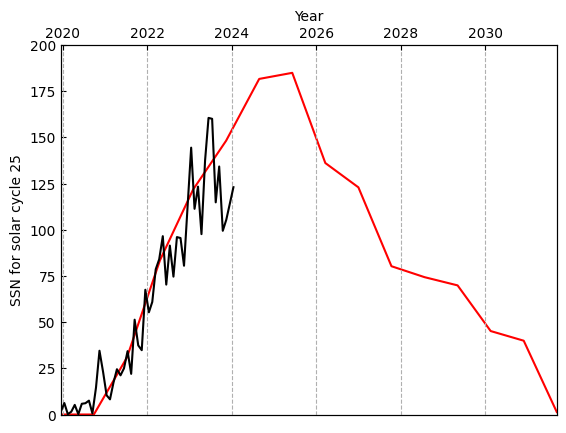

In [21]:
data_25 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sc25input.csv", sep=';', header = 0)

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(range(1,17), ssn_res[24], color='red')
ax2.plot(data_25['yearfrac'], data_25['ssn'], color='black')
#ax1.axhline(y=124, xmax = 0.26, color='black', linestyle='--')
ax1.set_xlim(1,16)
ax1.set_ylim(0,200)
ax2.set_xlim(2019.958, 2019.958+16*8.8/12) # верхняя граница предсказывается, не cycles_data
#ax1.set_xlabel('Номер фазы')
ax2.set_xlabel('Year')
ax1.set_ylabel('SSN for solar cycle 25')
ax1.tick_params(axis='both', direction='in', labelbottom=0, bottom=0), ax2.tick_params(axis='both', direction='in')
ax2.grid(visible='True', which='major', linestyle='--')
plt.show()

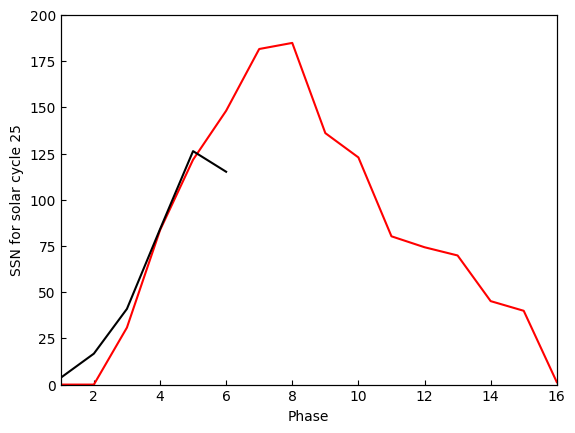

In [24]:
# здесь сравнивается усредненная по 16 фазам структура реальных данных 25 цикла и спрогнозированных. после настоящей фазы (они по 8.8 мес каждая) построила прямую
data25 = [3.715909091, 16.74090909, 40.95909091, 84.03863636, 126.3295455, 115.16667]
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(range(1,17), ssn_res[24], color='red')
ax2.plot(range(1,7), data25[:6], color='black')
ax1.set_xlim(1,16)
ax1.set_ylim(0,200)
ax2.set_xlim(1,16)
ax1.set_xlabel('Phase')
ax1.set_ylabel('SSN for solar cycle 25')
ax1.tick_params(axis='both', direction='in', labelbottom=1, bottom=1), ax2.tick_params(axis='both', direction='in', labeltop=0, top=0)
plt.show()

вариант 2) статистические закономерности: во-первых, правило Гневышева-Оля выполняется: в 24 цикле число пятен в максимуме около 140, в 25 цикле по прогнозу - около 180.


> "Так, в исследовании Гневышева и Оля (Gnevyshev, Ohl, 1948) была обнаружена связь между амплитудами соседних солнечных циклов: если нумеровать циклы так, что первый из них начался в 1755 году, то в максимуме нечетного цикла число пятен больше, чем в максимуме предыдущего четного. Для этого правила есть исключения в виде пар циклов 4/5 и 22/23."

во-вторых, по закону Вальмайера, уточненному Дмитриевой И. В. и др. в 2000 году:
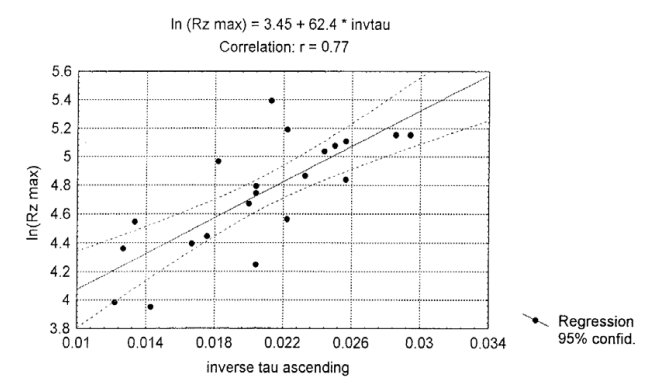

то есть, при максимуме в 184 пятна на восходящую ветвь должно приходиться 2,646 года, при максимуме в 160 пятен - 2,849 года. Для 24 цикла, например, это не выполняется: должно было понадобиться 3 года, а понадобилось 5 лет.